In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider, fixed , Output
from IPython.display import display
from sklearn.linear_model import LinearRegression

In [65]:
# Load data
data_300 = pd.read_csv("300_deg_diff_sr.csv")
data_535 = pd.read_csv("535_deg_diff_sr.csv")
epsT_full_300 = np.array(data_300["Strain"], dtype=float)
epsT_full_535 = np.array(data_535["Strain"], dtype=float)
stresses_300 = [c for c in data_300.columns if c != "Strain"]
stresses_535 = [c for c in data_535.columns if c != "Strain"]
stress_matrix_300 = data_300[stresses_300].to_numpy()
stress_matrix_535 = data_535[stresses_535].to_numpy()
params_by_temp = {
    "300": dict(E=26000.0, k=40.0, K=220.0, n1=1.0, A=4.0, C=0.7, n2=1.5, B=180.0),
    "535": dict(E=26000.0, k=40.0, K=220.0, n1=1.0, A=4.0, C=0.7, n2=1.5, B=180.0)
}

In [ ]:
# numerical scheme 

def simulate_sigma_euler(
    epsT: np.ndarray,          # true strain array (monotonic increasing)
    SR: float,                 # strain rate (1/s)
    E: float, k: float, K: float, n1: float,
    A: float, C: float, n2: float,
    B: float,
    eps_p0: float = 0.0,
    rho0: float = 1e-4,
    rho_floor: float = 1e-12,
    n_sub: int = 1,            # set to e.g. 10, 50 if it jumps
):
    """
    Backward  Euler on eps_p and rho, with algebraic R = B*sqrt(rho).
    Returns sigma_model, eps_p_hist, rho_hist, R_hist
    All stress-like quantities must be in consistent units (e.g., MPa everywhere).
    """

    # ensure epsT is np.array
    epsT = np.asarray(epsT, dtype=float)
    # number of sigma values to generate
    N = len(epsT)

    sigma = np.zeros(N)
    eps_p = np.zeros(N)
    rho = np.zeros(N)
    R = np.zeros(N)

    # intialise plastic strain as zero
    eps_p[0] = eps_p0

    # why is rho bounded?
    rho[0] = max(rho0, rho_floor)
    R[0] = B * np.sqrt(rho[0])
    sigma[0] = E * (epsT[0] - eps_p[0])

    # sub-stepping routine for stability 
    for i in range(1, N):
        # compute strain step size
        d_epsT = epsT[i] - epsT[i-1]
        # compute time step size
        dt = d_epsT / SR

        # substepping (optional but very effective)
        dt_sub = dt / n_sub
        epsT_sub0 = epsT[i-1]

        epp = eps_p[i-1]
        r = rho[i-1]
        
        # if we have instability we can reduce the time step
        for s in range(n_sub):
            # linearl
            epsT_s = epsT_sub0 + (s + 1) * (d_epsT / n_sub)

            r = max(r, rho_floor)
            R_s = B * np.sqrt(r)
            sigma_s = E * (epsT_s - epp)

            drive = (sigma_s - R_s - k) / K
            epp_dot = max(drive, 0) ** n1

            r_dot = A * (1.0 - r) * epp_dot - C * (r ** n2)

            # Euler update
            epp = epp + epp_dot * dt_sub
            r = r + r_dot * dt_sub

            r = max(r, rho_floor)

        eps_p[i] = epp
        rho[i] = r
        R[i] = B * np.sqrt(rho[i])
        sigma[i] = E * (epsT[i] - eps_p[i])

    return sigma, eps_p, rho, R


In [ ]:
# Interactive plotting function
def plot_simulation(temp, E, k, K, n1, A, C, n2, B):
    with output_model:
        output_model.clear_output(wait=True)  # Clear previous plot
        sigma_exp = full_data[temp].to_numpy()
        mask = ~np.isnan(sigma_exp)
        epsT = epsT_full[mask]
        sigma_exp = sigma_exp[mask]
        
        sigma_model, _, _, _ = simulate_sigma_euler(
            epsT=epsT,
            SR=SR,
            E=E, k=k, K=K, n1=n1, A=A, C=C, n2=n2, B=B,
            rho0=1e-4,
            n_sub=1
        )
        
        plt.figure(figsize=(5, 3))
        plt.title(f"Simulation and experiment plot for {temp}°C", fontsize=12)
        plt.plot(epsT, sigma_model, label='Model', color='blue')
        plt.scatter(epsT, sigma_exp, label='Experiment', color='red', alpha=0.7, s=15)
        plt.xlabel('Strain', fontsize = 10)
        plt.ylabel('Stress (MPa)', fontsize = 10)
        plt.legend()
        plt.grid(True)
        plt.show()


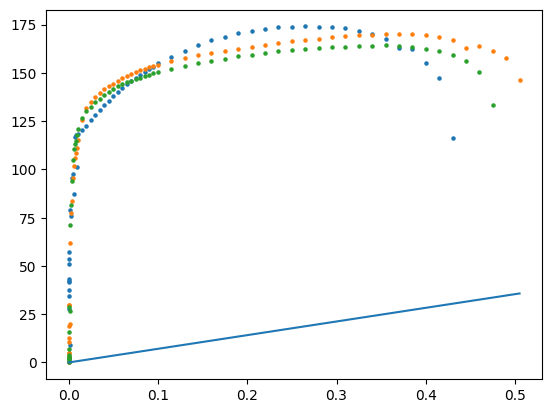

In [49]:
strain_rates = [0.1, 1, 5]
low_temp_params = dict(E=70.79, k=1834.159, K=803.875, n1=1861.927, A=433.444, C=-923.743, n2=1.8, B=682.781)
for i in range(3):
    plt.scatter(epsT_full_300, stress_matrix[:, i], s=5)
    
    if i == 2:
        sigma_model, _, _, _ = simulate_sigma_euler(
            epsT=epsT_full_300,
            SR=strain_rates[i],
            **low_temp_params,
            rho0=1e-4,
            n_sub=1
        )
        plt.plot(epsT_full_300, sigma_model)

plt.show()

In [64]:
# Create an Output widget for the plot
output = Output()

# Interactive plotting function
def plot_simulation(temp, E, k, K, n1, A, C, n2, B, strains, stress_data, strain_data):
    with output:
        output.clear_output(wait=True)  # Clear previous plot

        
        plt.figure(figsize=(8, 6))
        plt.title(f"Simulation and experiment plot for {temp}°C")
        for i in range(len(strains)):
            sigma_exp = stress_data[:, i]
            mask = ~np.isnan(sigma_exp)
            epsT = strain_data[mask]
            sigma_exp = sigma_exp[mask]

            sigma_model, _, _, _ = simulate_sigma_euler(
                epsT=epsT,
                SR=strains[i],
                E=E, k=k, K=K, n1=n1, A=A, C=C, n2=n2, B=B,
                rho0=1e-4,
                n_sub=10
            )
            plt.plot(epsT, sigma_model, label=f'Model, sr = {strains[i]}')
            plt.scatter(epsT, sigma_exp, label=f'Experiment, sr = {strains[i]}', alpha=0.7, s=5)

        plt.xlabel('Strain')
        plt.ylabel('Stress (MPa)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Create interactive widgets

E_slider = FloatSlider(min=1000, max=80000, step=500, value=30000, description='E (MPa):')
k_slider = FloatSlider(min=0, max=200, step=1, value=50, description='k (MPa):')
K_slider = FloatSlider(min=10, max=500, step=1, value=200, description='K (MPa):')
n1_slider = FloatSlider(min=0.01, max=2, step=0.05, value=1.0, description='n1:')
A_slider = FloatSlider(min=0.01, max=5, step=0.05, value=5.0, description='A:')
C_slider = FloatSlider(min=1, max=200, step=1, value=0.5, description='C:')
n2_slider = FloatSlider(min=0.1, max=5, step=0.1, value=1.5, description='n2:')
B_slider = FloatSlider(min=10, max=500, step=1, value=200, description='B (MPa):')

# Display the output widget
display(output)

strain_rates = [0.1, 1, 5]
# Use interact to create the interactive plot
interact(plot_simulation,
         temp = fixed(300),
         E=E_slider, 
         k=k_slider, 
         K=K_slider, 
         n1=n1_slider, 
         A=A_slider, 
         C=C_slider, 
         n2=n2_slider, 
         B=B_slider, 
         strains=fixed(strain_rates),
         stress_data=fixed(stress_matrix_300),
         strain_data=fixed(epsT_full_300))

Output()

interactive(children=(FloatSlider(value=30000.0, description='E (MPa):', max=80000.0, min=1000.0, step=500.0),…

<function __main__.plot_simulation(temp, E, k, K, n1, A, C, n2, B, strains, stress_data, strain_data)>

# 535°C 

In [ ]:
# Create an Output widget for the plot
output_1 = Output()

# Interactive plotting function
def plot_simulation(temp, E, k, K, n1, A, C, n2, B, strains, stress_data, strain_data):
    with output:
        output.clear_output(wait=True)  # Clear previous plot

        
        plt.figure(figsize=(8, 6))
        plt.title(f"Simulation and experiment plot for {temp}°C")
        for i in range(len(strains)):
            sigma_exp = stress_data[:, i]
            mask = ~np.isnan(sigma_exp)
            epsT = strain_data[mask]
            sigma_exp = sigma_exp[mask]

            sigma_model, _, _, _ = simulate_sigma_euler(
                epsT=epsT,
                SR=strains[i],
                E=E, k=k, K=K, n1=n1, A=A, C=C, n2=n2, B=B,
                rho0=1e-4,
                n_sub=10
            )
            plt.plot(epsT, sigma_model, label=f'Model, sr = {strains[i]}')
            plt.scatter(epsT, sigma_exp, label=f'Experiment, sr = {strains[i]}', alpha=0.7, s=5)

        plt.xlabel('Strain')
        plt.ylabel('Stress (MPa)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Create interactive widgets

E_slider = FloatSlider(min=1000, max=80000, step=500, value=30000, description='E (MPa):')
k_slider = FloatSlider(min=0, max=200, step=1, value=50, description='k (MPa):')
K_slider = FloatSlider(min=10, max=500, step=1, value=200, description='K (MPa):')
n1_slider = FloatSlider(min=0.01, max=2, step=0.05, value=1.0, description='n1:')
A_slider = FloatSlider(min=0.01, max=5, step=0.05, value=5.0, description='A:')
C_slider = FloatSlider(min=1, max=200, step=1, value=0.5, description='C:')
n2_slider = FloatSlider(min=0.1, max=5, step=0.1, value=1.5, description='n2:')
B_slider = FloatSlider(min=10, max=500, step=1, value=200, description='B (MPa):')

# Display the output widget
display(output)

strain_rates = [0.1, 1, 5]
# Use interact to create the interactive plot
interact(plot_simulation,
         temp = fixed(535),
         E=E_slider, 
         k=k_slider, 
         K=K_slider, 
         n1=n1_slider, 
         A=A_slider, 
         C=C_slider, 
         n2=n2_slider, 
         B=B_slider, 
         strains=fixed(strain_rates),
         stress_data=fixed(stress_matrix_535),
         strain_data=fixed(epsT_full_535))

Output()

interactive(children=(FloatSlider(value=30000.0, description='E (MPa):', max=80000.0, min=1000.0, step=500.0),…

<function __main__.plot_simulation(temp, E, k, K, n1, A, C, n2, B, strains, stress_data, strain_data)>